# Halite Unofficial Scoring

I believe we can make a "better" final score. 

First, the official Halite scores are very frothy. Even in the top ten, you can go up or down in rank with just a few games. Once you to about rank 50, your rank can vary easily by 10 places. The reason for this is that Trueskill's default parameters are set so that your actual skill can increase or decrease over time. Essentially it does this by giving far less weight to past games then it does to recent ones. While this is great for humans, for the task of finely ranking bots that stay the same, we really want to use information from all games.

Secondly, there were rumors of two short periods with elevated timeout rates. This penalized some bots a lot more than others. We want identify the extent of this effect, and figure out the cleanest way of removing it.

## Personal Bias

I have a bot in offical rank #38. I'm not contesting for a top spot. I belive my bot handles periods of increased server load well, and actauly benifts from other bots timing out. I therefor expect that my own ranking will go down in these unoffical scorings.

## Let's get started

In [1]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

from halitedata import load_all_games
from halitedata import score_with_default_trueskill
from halitecharts import *
import trueskill

In [2]:
games = load_all_games()

## Too many timeouts

Are there realy periods with increased timeouts, or is this just a rumor?

To determine this, lets plot errors per thousand over time

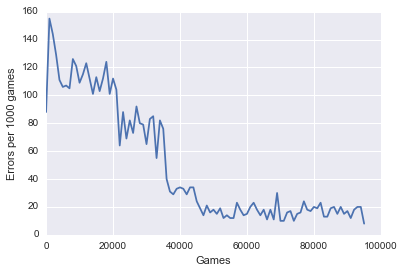

In [44]:
def plot_errors_per_game(games, games_per_bucket=1000):
    num_buckets = (len(games) / games_per_bucket + 1)
    error_buckets = [0] * num_buckets
    for i, game in enumerate(games):
        if game.has_error:
            bucket_i = i / games_per_bucket
            error_buckets[bucket_i] += 1
    sns.set_style("darkgrid")
    plt.ylabel('Errors per %d games' % games_per_bucket)
    plt.xlabel('Games')
    plt.plot(range(0, num_buckets * games_per_bucket, games_per_bucket), error_buckets)
    plt.ylim(ymin=0)

plot_errors_per_game(games, 1000)

Now that looks like terrifying errors early on, but the seeding changed partway through the finals. Later on, only higher ranked bots played, so a lot of new player erros should go away. Let's see what the error rate looks like for players in the top 100.

In [12]:
trueskill.setup(tau=0.01)
players_low_low_tau = score_with_default_trueskill(games) # Takes a few minutes

Loading Games
5000 of 95562
10000 of 95562
15000 of 95562
20000 of 95562
25000 of 95562
30000 of 95562
35000 of 95562
40000 of 95562
45000 of 95562
50000 of 95562
55000 of 95562
60000 of 95562
65000 of 95562
70000 of 95562
75000 of 95562
80000 of 95562
85000 of 95562
90000 of 95562
95000 of 95562
Done


In [19]:
top_players = [x[0] for x in leaderboard(players_low_low_tau, 200)]
top_players[0]

u'mzotkiew'

In [21]:
top_players_set = set(top_players)
games_with_top_players = [game for game in games if any(user.user_name in top_players_set for user in game.users)]
len(games_with_top_players)

32957

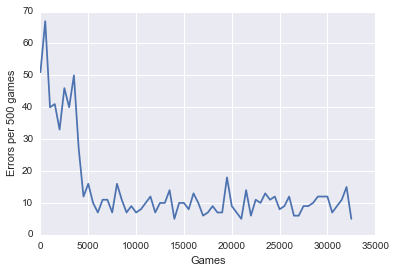

In [29]:
plot_errors_per_game(games_with_top_players, 500)

Clearly one period of high errors at the start of the contest.

If we ignore those first 5000 top games, we should be good. Let's find a game id, and only use games after that for scoring.

In [36]:
after_errors_games_id = games_with_top_players[5001].id
after_errors_games_id

u'2357704'

69260

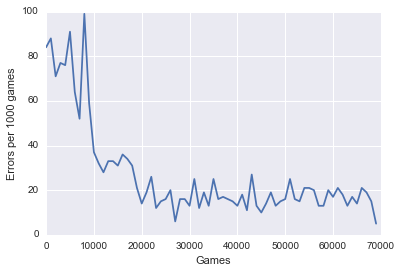

In [38]:
good_games = [game for game in games if game.id >= after_errors_games_id]
plot_errors_per_game(good_games, 1000)
len(good_games)

Using that still looks alarming, but that is only the lower ranked bots effect.

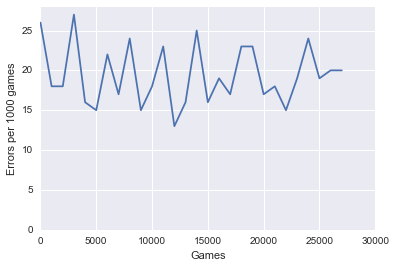

In [45]:
good_games_with_top_players = [game for game in good_games if any(user.user_name in top_players_set for user in game.users)]
plot_errors_per_game(good_games_with_top_players, 1000)

Looks pretty natural. Way better.

# Taking all games into account

The `Tau` factor in the Trueskill ranking algorithm adds additional, unwarranted uncertainty after every game. This makes the past history matter less and less, and is vital for people, who change in skill over time. 

For bots though, we want to take into account the entire gameplay history we have available. A `tau` of zero should do this.

In [47]:
trueskill.setup(tau=0.00)
players_no_tau = score_with_default_trueskill(good_games)

Loading Games
5000 of 69260
10000 of 69260
15000 of 69260
20000 of 69260
25000 of 69260
30000 of 69260
35000 of 69260
40000 of 69260
45000 of 69260
50000 of 69260
55000 of 69260
60000 of 69260
65000 of 69260
Done


In [48]:
trueskill.setup(tau=0.08333333333333333)
players_default_tau = score_with_default_trueskill(good_games)

Loading Games
5000 of 69260
10000 of 69260
15000 of 69260
20000 of 69260
25000 of 69260
30000 of 69260
35000 of 69260
40000 of 69260
45000 of 69260
50000 of 69260
55000 of 69260
60000 of 69260
65000 of 69260
Done


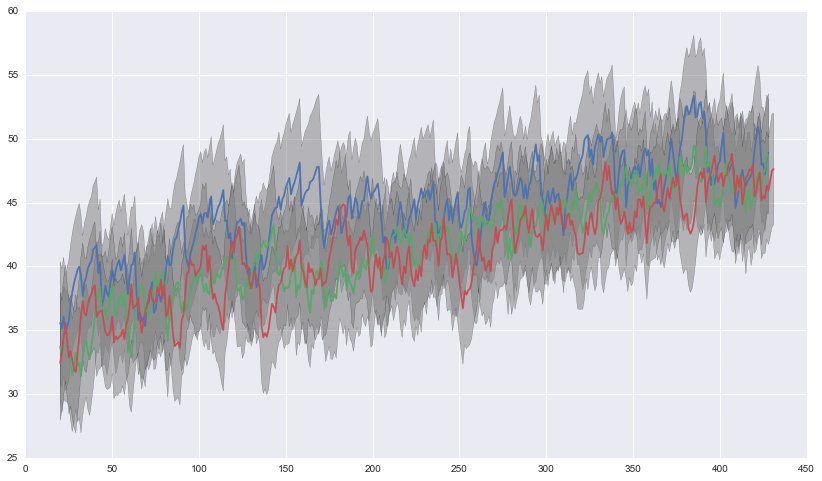

In [54]:
plot_compare(players_default_tau,["mzotkiew","shummie","erdman"])

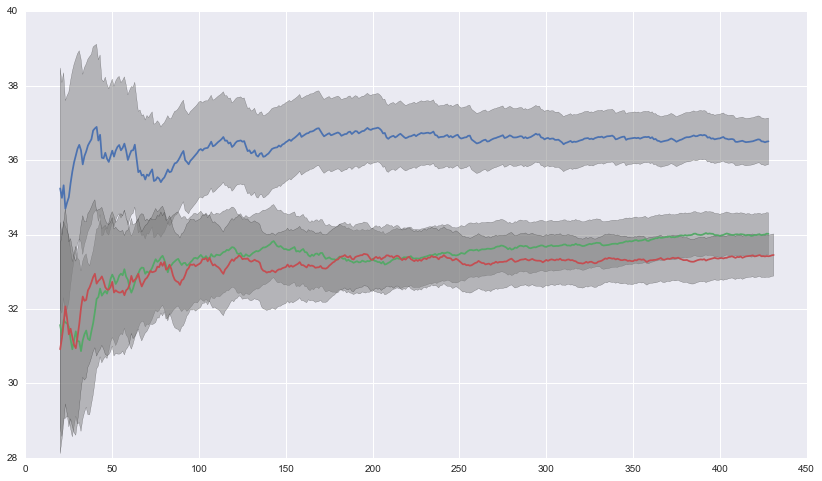

In [55]:
plot_compare(players_no_tau,["mzotkiew","shummie","erdman"])

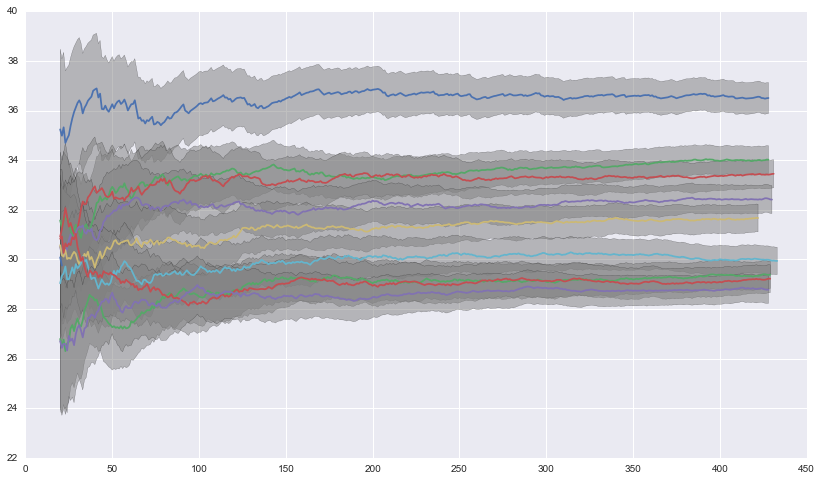

In [61]:
plot_compare(players_no_tau,leaderboard_user_names(players_no_tau, 10))


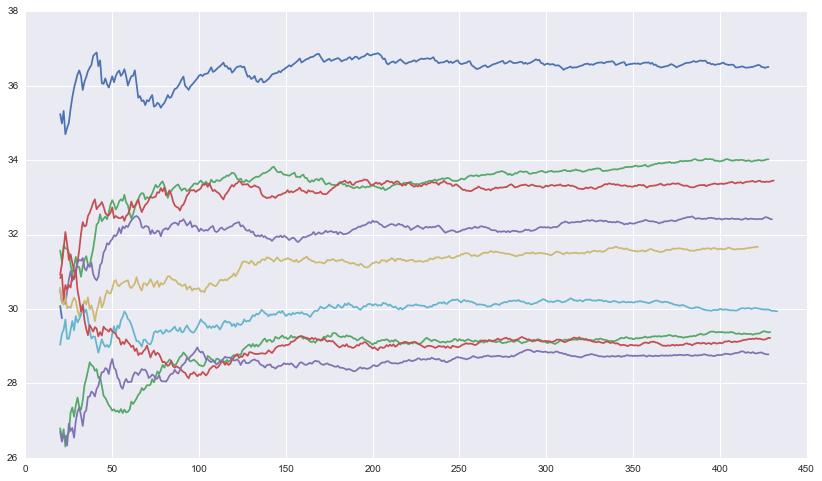

In [62]:
plot_compare(players_no_tau,leaderboard_user_names(players_no_tau, 10), show_sigma=False)

In [63]:
leaderboard_user_names(players_no_tau, 10)

[u'mzotkiew',
 u'shummie',
 u'erdman',
 u'timfoden',
 u'cdurbin',
 u'nmalaguti',
 u'aw1231',
 u'PeppiKokki',
 u'DexGroves',
 u'ewirkerman']

In [67]:
for i, user_name in enumerate(leaderboard_user_names(players_no_tau, 200)):
    if i % 10 == 0:
        print ""
    print "#%d %s"%(i+1, user_name)


#1 mzotkiew
#2 shummie
#3 erdman
#4 timfoden
#5 cdurbin
#6 nmalaguti
#7 aw1231
#8 PeppiKokki
#9 DexGroves
#10 ewirkerman

#11 toshima
#12 christian-mejia
#13 s4chin
#14 sundoop
#15 danielfrg
#16 dasilvacontin
#17 moonbirth
#18 MichaelScript
#19 kyledotterrer
#20 Adeimantius

#21 MrRazorlike
#22 Beavesy
#23 chensy1992
#24 tomlinton
#25 veden
#26 KalraA v92
#27 bicro
#28 Tibblist
#29 twg16 v2
#30 MoreGames

#31 severb
#32 TheProdigy22
#33 sid-code
#34 acouette
#35 kitttn
#36 Zantus
#37 ahikiran
#38 asishm
#39 64BitsPerMinute
#40 jgriffau

#41 tondonia
#42 kevinzwb
#43 stevelee55
#44 koolkid311
#45 hkilian
#46 SrinidhiPalwayi
#47 sheldonsmickley
#48 Shahan83
#49 jburditt
#50 zihaozhu0025

#51 haiyaoliu
#52 sydbodz
#53 tmseiler
#54 fohristiwhirl
#55 Bertinus
#56 jstaker7
#57 Virenz123
#58 vganesh46
#59 chssch
#60 Psykoangel

#61 bouwkast
#62 halitetester10
#63 Jenkyrados
#64 KyleYu
#65 appp1337
#66 ardimaria
#67 jobi-k
#68 Suhas7
#69 j4panimation
#70 rahenri

#71 Xrayez
#72 philglazer
#73

# That's not going to fly

It looks like Trueskill really needs its early games against clear winners and loosers. At lot of these rankings are wildy different than observed reality.

I'm going to try just dropping games with errors, instead of the first part of the contest.

In [72]:
games_no_errors = [game for game in games if game.has_error == False]
len(games_no_errors)

90817

In [85]:
trueskill.setup(tau=0.08333333333333333)
no_errors_default_tau = score_with_default_trueskill(games_no_errors)

Loading Games
5000 of 90817
10000 of 90817
15000 of 90817
20000 of 90817
25000 of 90817
30000 of 90817
35000 of 90817
40000 of 90817
45000 of 90817
50000 of 90817
55000 of 90817
60000 of 90817
65000 of 90817
70000 of 90817
75000 of 90817
80000 of 90817
85000 of 90817
90000 of 90817
Done


In [86]:
trueskill.setup(tau=0.0)
no_errors_no_tau = score_with_default_trueskill(games_no_errors)

Loading Games
5000 of 90817
10000 of 90817
15000 of 90817
20000 of 90817
25000 of 90817
30000 of 90817
35000 of 90817
40000 of 90817
45000 of 90817
50000 of 90817
55000 of 90817
60000 of 90817
65000 of 90817
70000 of 90817
75000 of 90817
80000 of 90817
85000 of 90817
90000 of 90817
Done


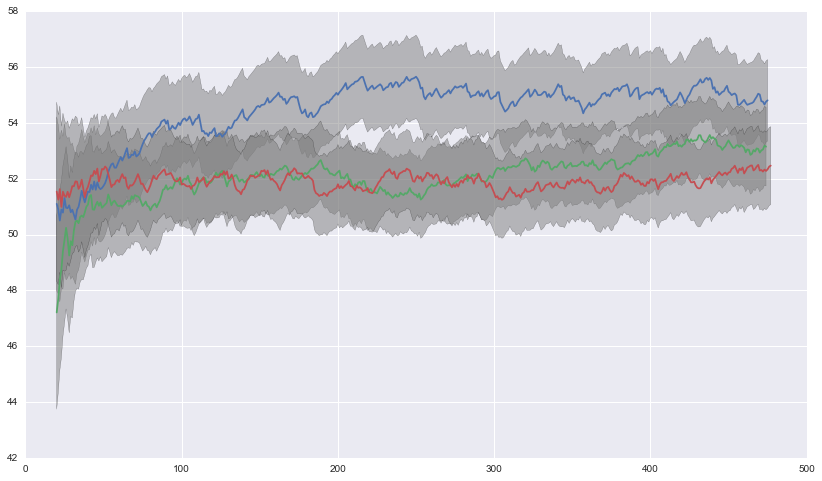

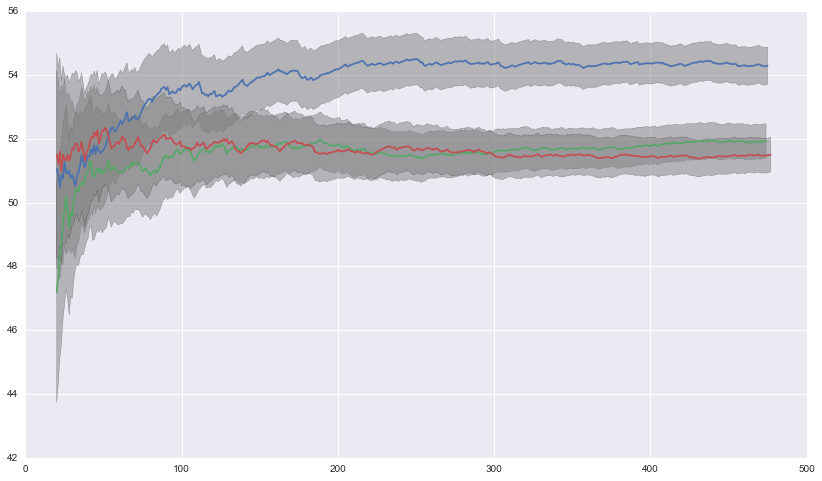

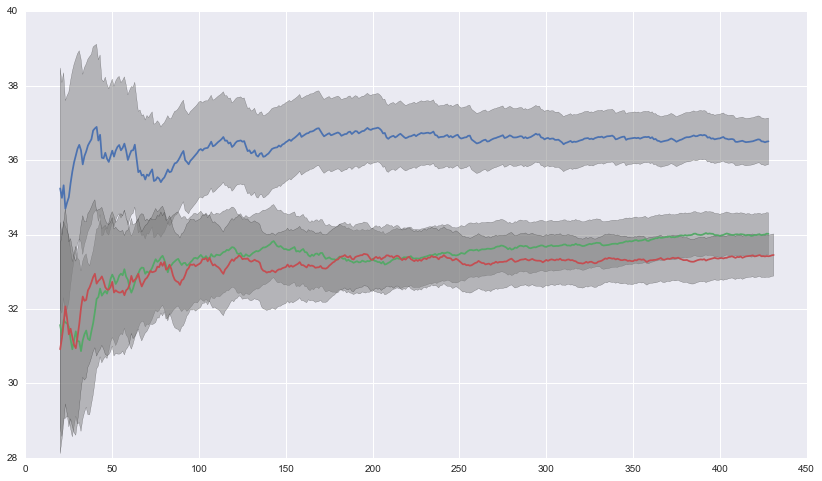

In [79]:
plot_compare(no_errors_default_tau,["mzotkiew","shummie","erdman"])
plot_compare(no_errors_no_tau,["mzotkiew","shummie","erdman"])
plot_compare(players_no_tau,["mzotkiew","shummie","erdman"])

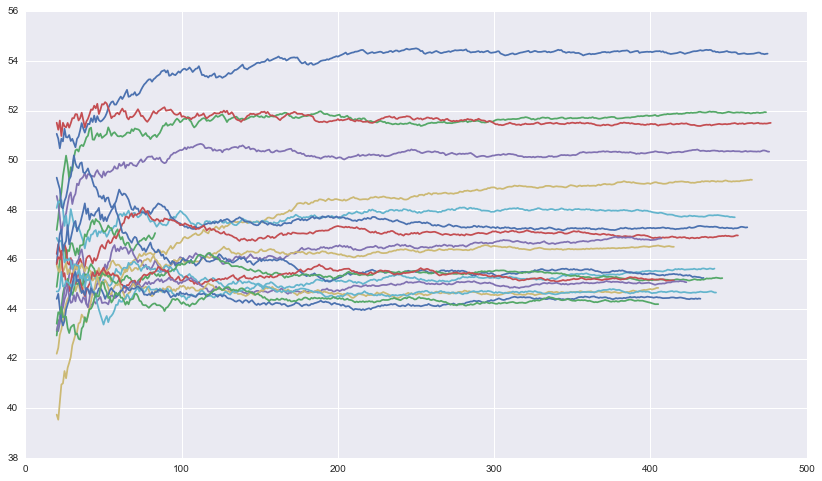

In [83]:
plot_compare(no_errors_no_tau,leaderboard_user_names(no_errors_no_tau, 20), show_sigma=False)

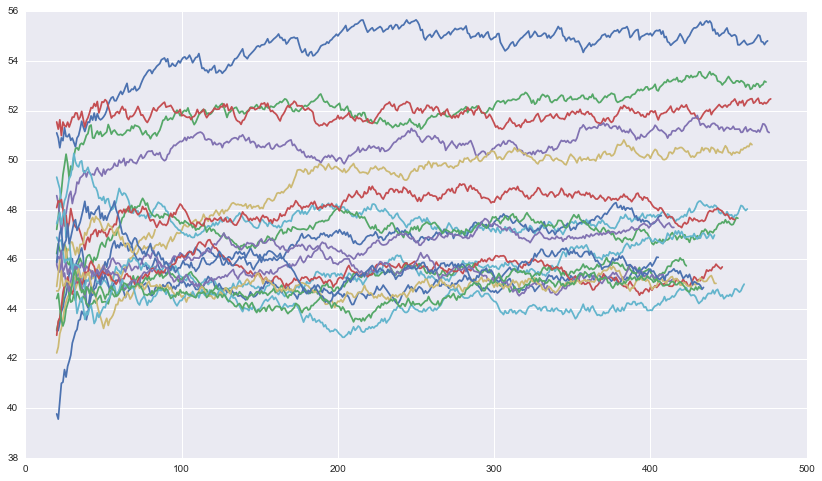

In [87]:
plot_compare(no_errors_default_tau, leaderboard_user_names(no_errors_default_tau, 20), show_sigma=False)

In [89]:
i = 0
for user_name in leaderboard_user_names(no_errors_no_tau, 201):
    if user_name == "KalraA v91":
        continue
    if i % 10 == 0:
        print ""
    print "#%d %s"%(i+1, user_name)
    i += 1


#1 mzotkiew
#2 shummie
#3 erdman
#4 timfoden
#5 cdurbin
#6 nmalaguti
#7 PeppiKokki
#8 DexGroves
#9 KalraA v92
#10 ewirkerman

#11 moonbirth
#12 acouette
#13 MoreGames
#14 Ziemin
#15 jstaker7
#16 veden
#17 tondonia
#18 fohristiwhirl
#19 tmseiler
#20 cdmurray80

#21 Maximophone
#22 bencalderhead
#23 En3rG
#24 djma
#25 davidgratton
#26 daniel-shields
#27 JWGS1
#28 yangle
#29 frabi
#30 david-wu

#31 bouwkast
#32 varak69
#33 GaudyZircon
#34 hmate9
#35 Gullesnuffs
#36 b7500af1
#37 TheDuck314
#38 danielborowski
#39 breeko
#40 BigBallerShotCaller

#41 DanielVF
#42 Daniel-Wang
#43 Oreshnik
#44 schmit
#45 MrTwiggy
#46 other-ai
#47 jediahkatz
#48 Sydriax
#49 hyPiRion
#50 kindanoob

#51 MHeasell
#52 bengo1023
#53 alexhad6
#54 0x0L
#55 brianvanleeuwen
#56 Kaczmarczyck
#57 dbf256
#58 kragbot
#59 kbcole
#60 arjunvis

#61 jheilema-nerdery
#62 henripal
#63 Vlad-Shcherbina
#64 bveber
#65 jiatinglu99
#66 markstev
#67 happypepper
#68 hilkoc
#69 jwcdbd
#70 sam-huang1223

#71 sanjeevtewani
#72 adrienball
#